# **IMPORT THƯ VIỆN**

In [ ]:
# import thư viện

# Cài các thư viện cần thiết
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

#https://www.stockbiz.vn/Stocks/dap/LookupQuote.aspx
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chromium import options
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup as BS
import urllib.request
import matplotlib.pyplot as plt
from time import sleep
import datetime
from IPython.display import clear_output
!pip install tslearn
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import datasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use("fivethirtyeight") 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 4.3 MB/s 
     |████████████████████████████████| 384 kB 65.0 MB/s 
     |████████████████████████████████| 140 kB 29.4 MB/s 
     |████████████████████████████████| 58 kB 5.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.13 which is incompatible.
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security In

In [ ]:
# set up cho request
chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome(executable_path='/usr/bin/chromedriver',chrome_options = chrome_options)


<ipython-input-2-e330e3e72e27>:5: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path='/usr/bin/chromedriver',chrome_options = chrome_options)
<ipython-input-2-e330e3e72e27>:5: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(executable_path='/usr/bin/chromedriver',chrome_options = chrome_options)


# **TASK 1**

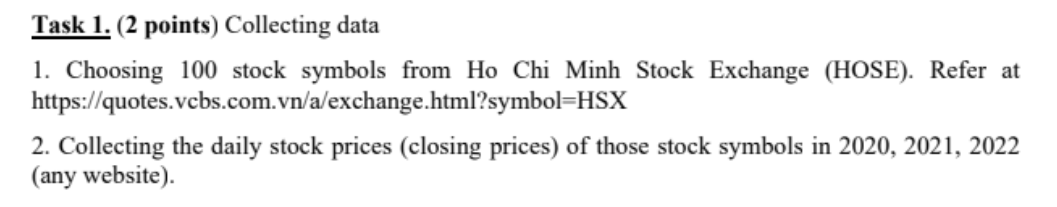

In [ ]:
class DataFrameSecuritie:
  def __init__(self):
    # lưu danh sách ngày
    self.listDay = self.getListDay()
    # lưu danh sách mã chứng khoán
    self.listStockCode = self.getListStockCode()
    # danh sách các danh sách giá đống cửa của các mã chứng khoán
    self.data = self.getData()
    # dataframe 
    self.df =  self.createDataFrame()
  def getListDay(self):
    # tạo list danh sách ngày
    lst =[]
    # ngày day bắt đầu từ 31-10-2022 đến 1/1/2020, bước nhảy -1
    day = datetime.datetime(2022,10,31)
    # chuyển day thành str
    strDay = day.strftime("%d/%m/%Y")
    # Thêm ngày đầu tiên vào listDay
    lst.append(strDay)
    # thực hiện vòng lập đến khi t2 bằng ngày 01/01/2020
    while (strDay!='01/01/2020'):
      # giảm day xuống 1 ngày
      day = day + datetime.timedelta(days=-1)
      # chuyển day thành string
      strDay = day.strftime("%d/%m/%Y")
      # thêm day vào list
      lst.append(strDay)
    return lst[::-1]

  def getListStockCode(self):
    # list rỗng
    lst = []
    # trang web để cào danh sách mã chứng khoán
    url =  'http://stockboard.sbsc.com.vn/apps/StockBoard/SBSC/HOSE.html'
    # Truy cập vào đường dẫn
    driver.get(url)
    #Tạm ngưng 10s để driver loading data
    sleep(10)
    # lấy dữ liệu html
    html = driver.execute_script("return document.getElementsByTagName('html')[0].innerHTML")
    soup = BS(html,"html.parser")
    row =  soup.find('div', id= 'stockBoardRegion').find_all('th',class_='ss-down')
    # duyệt các dòng html, lấy dữ liệu
    for i in row:
        # chỉ lấy những mã có 3 chữ số.
        if(len(i.get_text().strip())==3):
          lst.append(i.get_text().strip())
    # ouput lst
    return lst
  
  #  hàm lấy data
  def getData(self):
      # list các list data của các mã chứng khoáng theo ngày
      data = []
      # hàm tạo ngày cuối của tháng theo ngày được truyền vào.
      def last_day_of_month(any_day):
              next_month = any_day.replace(day=28) + datetime.timedelta(days=4)  # this will never fail
              return next_month - datetime.timedelta(days=next_month.day)
      lstMonthOfYear = []
      # tạo danh sách lstMonthOfYear chứa các giá trị mm/YYYY trong thời gian từ 01/2020 đến 10/2022
      for year in range(2020,2023):
          for month in range(1, 13):
              if(  (year <2022) | (year== 2022 and month <11)):
                lstMonthOfYear.append(last_day_of_month(datetime.date(year, month, 1)).strftime("%d/%m/%Y"))
      # biến đếm tiến độ
      time = 0
      # biến đếm số mã đã quét
      count = 0
      # duyệt danh sách các mã
      for code in self.listStockCode :
          # biến đếm số mã đã quét +1
          count +=1
          # tạo dict dictDay với key là danh sách các ngày, value mặc định bằng = 0 
          dictDay={}
          for i in self.listDay:
            dictDay[i] =0
          # duyệt các mm/YYYY trong  lstMonthOfYear để cào dữ liệu
          for day in lstMonthOfYear:
            # tạo mã url với code và day
            url =  f'https://www.stockbiz.vn/Stocks/{code}/LookupQuote.aspx?Date={day}'
            print(url)
            # lấy mã html
            driver.get(url)
            # lấy dữ liệu html
            html = driver.execute_script("return document.getElementsByTagName('html')[0].innerHTML")
            soup = BS(html,"html.parser")
            price =  soup.find('table', class_= 'dataTable').find_all('tr')
            # chỉ lấy 31 dòng data đầu danh sách
            if( len(price) <31):
                continue
            # biến đếm tiến độ + 1
            time+=1
            # print thông tin tiến độ cào dữ liệu
            print("Số mã đã quét:", count,"/",len(self.listStockCode))
            print("Tiến độ:",(( time/(len(self.listStockCode)*34))*100),"%")
            # cho i chạy từ 1 tới 31
            for i in range (1,32):
              # lấy dữ liệu ngày
              day  = price[i].find_all('td')[0].get_text().strip()
              # lấy dữ liệu giá đống cửa của ngày day
              priceClose = float((price[i].find_all('td')[5].get_text().strip()).replace(",","."))
              # dựa vào day để gán value = priceClose 
              if day in dictDay:
                dictDay[day] = priceClose

          # thêm dictDay vào data
          data.append([ dictDay[i] for  i in dictDay])
      # hàm dùng để remove các giá trị 0 trong 1 list
      def remove_0(the_list):
          return [value for value in the_list if value != 0]
      # hàm dùng để sort list X theo thứ tự sort list Y
      def sort_list(X,Y):
          keydict = dict(zip(X, Y))
          X.sort(key=keydict.get,reverse=True)
          return X
      # sắp xếp lại danh sách mã chứng khoán theo thứ tự độ dài của data chứng khoán đó với các giá trị khác 0.
      self.listStockCode = sort_list(self.listStockCode, [len(remove_0(i)) for i in data])
      # sắp xếp lại data
      data = sorted(data, key = lambda a:len(remove_0(a)),reverse=True)
      # trả về giá trị data
      return data
  # hàm tạo dataframe
  def createDataFrame(self):
      df = pd.DataFrame.from_records(columns = self.listDay,index = self.listStockCode[:100:] ,data = self.data[:100:])
      return df
  # Hàm fit dữ liệu bị missing
  def fitData(self,df):
      # duyệt từng mã code chứng khoán
      for code in  list(df.head(0)):
        # biến giá trị sẽ được gán hiện tại
        temp = 0
        # biến DD/mm/YYYY đại diện cho dữ liệu ngày đầu tiên khác 0 của mã code đó
        index = 0

        # duyệt các hàng trong df.index để tìm index khác 0 đầu tiên
        for day in  df.index:
          # nếu giá trị của mã code tại ngày day khác 0 thì ngưng chương trình
          if(  float(df.loc[day].at[code]) != float(0)):
            index  = day
            break

        # thay thế giá trị từ ngày 1/1/2020 đến ngày index bằng giá trị tại ngày index
        for day in df.index:
          # 
          if day != index:
            df.loc[day].at[code] = df.loc[index].at[code]
            temp =  df.loc[day].at[code]
            break

        # thay thế giá trị  0 bằng giá trị temp
        for day in df.index:
          # nếu giá trị tại [day,code] = 0 thì gán giá trị đó bằng temp
            if  df.loc[day].at[code] == 0:
                df.loc[day].at[code]= temp
            # nếu giá trị tại [day,code] khác 0 thì gán temp =  giá trị tại [day:code]
            else:
              temp =  df.loc[day].at[code]
        
      return df
  # hàm export kết quả dataframe thành file csv
  def exportCSV(self):
      df = self.fitData(self,df)
      df.to_csv('data.csv', index=True) 
  


In [ ]:
dataFrameSecuritie = DataFrameSecuritie()



Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Tiến độ: 68.79872430900072 %
https://www.stockbiz.vn/Stocks/SAB/LookupQuote.aspx?Date=30/06/2020
Số mã đã quét: 117 / 166
Tiến độ: 68.81644223954642 %
https://www.stockbiz.vn/Stocks/SAB/LookupQuote.aspx?Date=31/07/2020
Số mã đã quét: 117 / 166
Tiến độ: 68.83416017009213 %
https://www.stockbiz.vn/Stocks/SAB/LookupQuote.aspx?Date=31/08/2020
Số mã đã quét: 117 / 166
Tiến độ: 68.85187810063785 %
https://www.stockbiz.vn/Stocks/SAB/LookupQuote.aspx?Date=30/09/2020
Số mã đã quét: 117 / 166
Tiến độ: 68.86959603118356 %
https://www.stockbiz.vn/Stocks/SAB/LookupQuote.aspx?Date=31/10/2020
Số mã đã quét: 117 / 166
Tiến độ: 68.88731396172926 %
https://www.stockbiz.vn/Stocks/SAB/LookupQuote.aspx?Date=30/11/2020
Số mã đã quét: 117 / 166
Tiến độ: 68.90503189227498 %
https://www.stockbiz.vn/Stocks/SAB/LookupQuote.aspx?Date=31/12/2020
Số mã đã quét: 117 / 166
Tiến độ: 68.92274982282069 %
https://www.stockbiz.vn/Stocks/SAB/LookupQuote.aspx?Date=31/

In [ ]:
# in danh sách chứng khoán
print("Danh sách mã chứng khoán:", end=" ")
for i in dataFrameSecuritie.listStockCode: print(i, end=", ")

Danh sách mã chứng khoán: ACL, ADS, AGM, ANV, APC, APG, ASM, BCE, BCG, BFC, BMC, BMP, BTP, BTT, C47, CCI, CCL, CIG, CII, CLL, CMX, CNG, CRE, CTD, CTF, CTI, D2D, DAG, DAH, DBD, DCL, DGW, DHG, DHM, DLG, DMC, DPG, DPR, DQC, FCN, FIR, FIT, FPT, FTS, GEG, GEX, GMD, HAG, HAH, HAR, HAX, HBC, HCD, HDB, HDC, HDG, HII, HMC, HPG, HPX, HQC, HSG, HT1, HTN, HVH, IBC, IDI, IJC, IMP, ITA, KDC, KDH, KHP, KMR, KSB, LCG, LGL, LSS, MCG, MSH, MWG, NAF, NBB, NKG, NLG, NT2, NVT, PC1, PET, PHC, PIT, PLP, PLX, PMG, POM, PPC, PTB, PTC, REE, SAB, SAM, SAV, SBT, SBV, SCR, SFG, SFI, SHA, SHI, SJF, SKG, SMC, STK, SZC, TCD, TCL, TCM, TCT, TEG, TGG, TIP, TLG, TLH, TNI, TRA, TTB, TV2, VGC, VHC, VHM, VIC, VID, VIP, VMD, VNE, VNM, VOS, VPB, VPD, VPH, VPI, VRE, VSH, YEG, ORS, VCG, BSI, CTR, DBT, QBS, BCM, VIB, EVF, HHP, NSC, HHV, ADG, ABS, CKG, PSH, BKG, TNH, SVD, SSB, DXS, KHG, 

In [ ]:
# tạo dataframe và export thành file csv
df = dataFrameSecuritie.createDataFrame()
dataFrameSecuritie.exportCSV()

# **TASK 2**

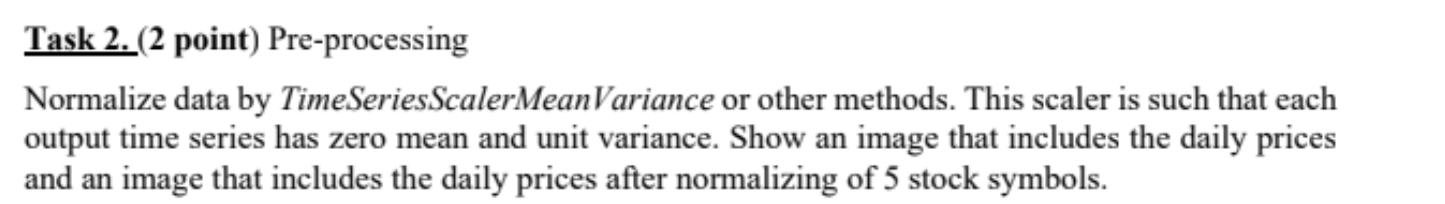

In [ ]:
# đọc file và in ra màn hình file csv đã export
df = pd.read_csv('/content/data.csv', index_col = 0)
display(df)

,ACL,ADS,AGM,ANV,APC,APG,ASM,BCE,BCG,BFC,...,PIT,PLP,PLX,PMG,POM,PPC,PTB,PTC,REE,SAB
01/01/2020,23.20,11.55,10.15,22.90,20.00,9.90,6.68,6.89,7.72,11.60,...,4.04,9.60,56.5,17.80,5.9,26.85,71.0,6.19,36.95,224.0
02/01/2020,23.20,11.55,10.15,22.90,20.00,9.90,6.68,6.89,7.72,11.60,...,4.04,9.60,56.5,17.80,5.9,26.85,71.0,6.19,36.95,224.0
03/01/2020,23.00,12.00,10.30,22.90,20.20,9.75,6.64,6.93,7.45,11.55,...,4.00,9.40,57.1,17.85,6.0,25.55,71.2,6.19,36.50,224.6
04/01/2020,23.00,12.00,10.30,22.90,20.20,9.75,6.64,6.93,7.45,11.55,...,4.00,9.40,57.1,17.85,6.0,25.55,71.2,6.19,36.50,224.6
05/01/2020,23.00,12.00,10.30,22.90,20.20,9.75,6.64,6.93,7.45,11.55,...,4.00,9.40,57.1,17.85,6.0,25.55,71.2,6.19,36.50,224.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27/10/2022,12.45,12.55,13.80,30.25,14.20,3.89,9.49,5.99,7.82,17.40,...,3.70,5.05,29.1,10.45,4.5,15.75,50.0,6.41,81.00,187.9
28/10/2022,12.30,12.70,13.95,29.80,14.20,3.99,9.62,6.10,7.96,17.60,...,3.95,5.10,29.0,10.45,4.4,15.45,50.6,6.29,79.80,186.1
29/10/2022,12.30,12.70,13.95,29.80,14.20,3.99,9.62,6.10,7.96,17.60,...,3.95,5.10,29.0,10.45,4.4,15.45,50.6,6.29,79.80,186.1
30/10/2022,12.30,12.70,13.95,29.80,14.20,3.99,9.62,6.10,7.96,17.60,...,3.95,5.10,29.0,10.45,4.4,15.45,50.6,6.29,79.80,186.1


              ACL    ADS    AGM    ANV    APC
01/01/2020  23.20  11.55  10.15  22.90  20.00
02/01/2020  23.20  11.55  10.15  22.90  20.00
03/01/2020  23.00  12.00  10.30  22.90  20.20
04/01/2020  23.00  12.00  10.30  22.90  20.20
05/01/2020  23.00  12.00  10.30  22.90  20.20
...           ...    ...    ...    ...    ...
27/10/2022  12.45  12.55  13.80  30.25  14.20
28/10/2022  12.30  12.70  13.95  29.80  14.20
29/10/2022  12.30  12.70  13.95  29.80  14.20
30/10/2022  12.30  12.70  13.95  29.80  14.20
31/10/2022  12.10  12.90  13.85  28.90  14.35

[1035 rows x 5 columns]
                 ACL       ADS       AGM       ANV       APC
01/01/2020  0.550790  0.095469  0.008604  0.202346  0.394366
02/01/2020  0.550790  0.095469  0.008604  0.202346  0.394366
03/01/2020  0.541761  0.110032  0.011472  0.202346  0.405634
04/01/2020  0.541761  0.110032  0.011472  0.202346  0.405634
05/01/2020  0.541761  0.110032  0.011472  0.202346  0.405634
...              ...       ...       ...       ...       

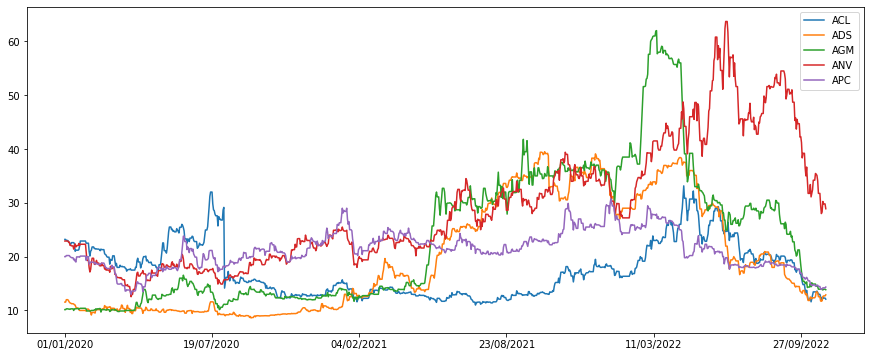

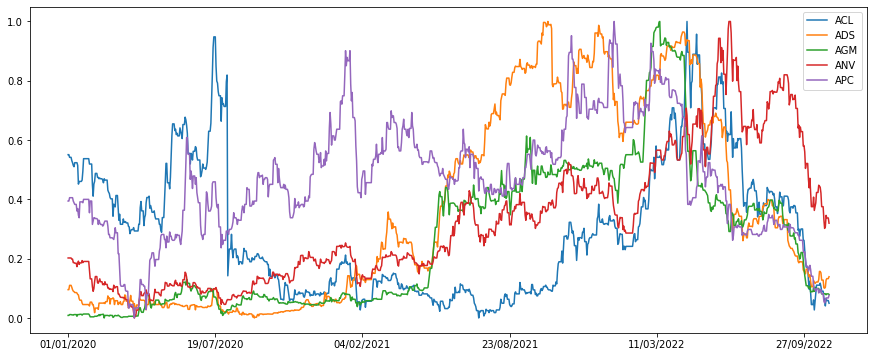

In [ ]:
class Pre_processing:
  def __init__(self,df):
    # dataframe 5 mã đầu chưa xử lí
    self.df1 = self.pre_processing(df,5)[0]
    # dataframe 5 mã đầu đã xử lí
    self.df2 = self.pre_processing(df,5)[1]

  def pre_processing(self,df,number):
    #tạo dataframe với 5 mã đầu tiên
    df1 = df.iloc[:,0:number]
    #Sử dụng MinMaxScaler để chia tỷ lệ dữ liệu thành phạm vi [0,1]
    min_max_Scalar = preprocessing.MinMaxScaler()
    #Biến đổi sử liệu theo MinMaxScaler
    result = min_max_Scalar.fit_transform(df1)
    #loại bỏ mean
    result.mean(axis=0)
    # loại bỏ độ lệch chuẩn
    result.std(axis=0)
    # tạo dataframe 2 với result đã được tiền xử lí dữ liệu
    df2 = pd.DataFrame(result, columns= df1.columns, index = df1.index)
    return df1, df2
    
  def drawChart(self):
    #Vẽ biểu đồ đường của 5 mã khi chưa chuẩn hóa
    print(self.df1)
    self.df1.plot(figsize=(15,6))
    #Vẽ biểu đồ đường của 5 mã khi đã chuẩn hóa  
    print(self.df2)
    self.df2.plot(figsize=(15,6))

pre_processing = Pre_processing(df)
pre_processing.drawChart()


# **TASK 3**

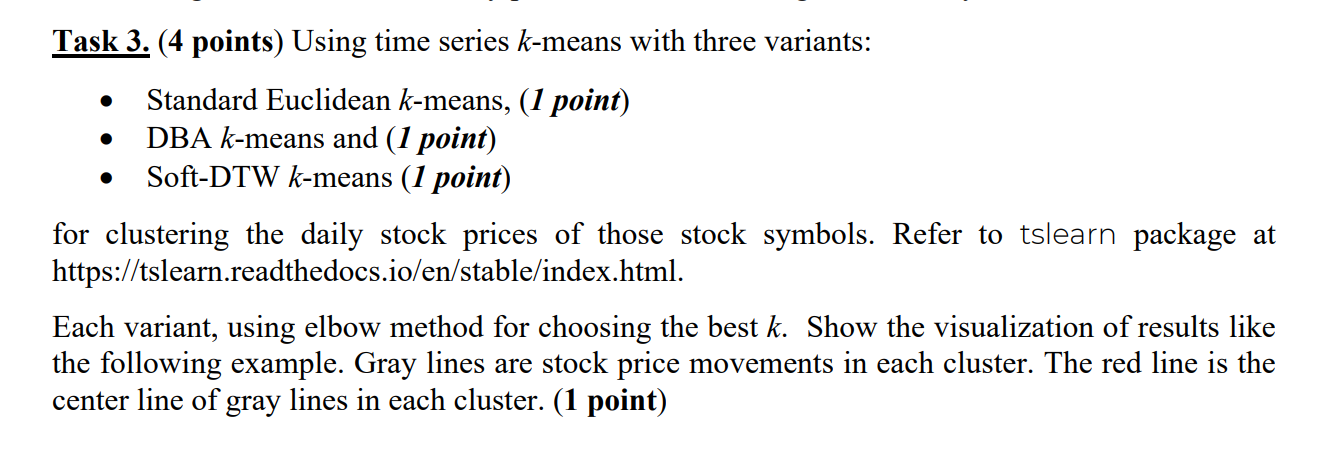

In [ ]:
class  TimeSeriesKmeans:
  def __init__(self,df0):
      # lấy dữ liệu 5 mã đầu đã được xử lí ở câu 2
      self.df = Pre_processing(df0).df2


  def elbow(self):
      # lấy dữ liệu df
      df  = self.df
      # list dùng để lưu trữ các biến dạng
      losses = []
      #chạy K-means cho các cụm bằng cách sử dùng vòng lặp for (Cho k chạy từ 1 tới 10)
      for i in range(1,11):
          # tạo model k-mean với k= i
          k_mean = KMeans(n_clusters = i)
          # train model với k = i
          k_mean.fit(df)
          # bỏ giá trị biến dạng vào list losses
          print(i,":",k_mean.inertia_)
          losses.append(k_mean.inertia_)
      #vẽ biểu đồ để xác định k       
      plt.plot([i for i in range(1,11)], losses, marker='*')
      plt.show()


  def  dataTrainning(self):
    df = self.df

    #Lưu dữ liệu lấy được dưới định dạng DataFrame     
    df = pd.DataFrame(df)
    #Chuyển đổi khung dữ liệu từ Pandas thành một mảng Numpy
    df_array = df.to_numpy()
    np.random.seed(0)
    np.random.shuffle(df_array)
    # Chỉ giữ 600 chuỗi thời gian
    df_array  = TimeSeriesScalerMeanVariance().fit_transform(df_array[:600])
    # Làm cho chuỗi thời gian ngắn hơn
    df_array = TimeSeriesResampler(sz=600).fit_transform(df_array)
    return df_array
  
  
  def Euclidean_Kmeans(self):
    seed = 0
    # lấy dữ liệu training từ hàm dataTrainning
    dataTrainning = self.dataTrainning()
    np.random.seed(seed)
    np.random.shuffle(dataTrainning)

    #Phân cụm dữ liệu cho chuỗi thời gian với thực thể euclidean
    km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed)
    #Điều chỉnh phân cụm k-mean bằng cách sử dụng phân cụm Trên tập dữ liệu
    #Sau đó dự đoán cụm gần nhất mà mỗi chuỗi thời gian trong tập dữ liệu thuộc về
    y_pred = km.fit_predict(dataTrainning)
    self.crawlDiagram(y_pred,dataTrainning,km)

  def DBA_Kmeans(self):
    seed = 0
    # lấy dữ liệu training từ hàm dataTrainning
    dataTrainning = self.dataTrainning()
    np.random.seed(seed)
    np.random.shuffle(dataTrainning)

    #Phân cụm dữ liệu cho chuỗi thời gian bằng cách sử dụng thực thể BDA
    km = TimeSeriesKMeans(n_clusters=3,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)
    #Điều chỉnh phân cụm K-mean bằng cách sử dụng phân cụm Trên tập dữ liệu
    #Sau đó dự đoán cụm gần nhất mà mỗi chuỗi thời gian trong tập dữ liệu thuộc về
    y_pred = km.fit_predict(dataTrainning)
    self.crawlDiagram(y_pred,dataTrainning,km)
  

  def SoftDTW_Kmeans(self):
    seed = 0
    np.random.seed(seed)
    # lấy dữ liệu training từ hàm dataTrainning
    dataTrainning = self.dataTrainning()

    #Phân cụm dữ liệu cho chuỗi thời gian bằng cách sử dụng thực thể BDA
    km = TimeSeriesKMeans(n_clusters=3,
                               metric="softdtw",
                               metric_params={"gamma": .01},
                               verbose=True,
                               random_state=seed)
    #Điều chỉnh phân cụm K-mean bằng cách sử dụng phân cụm Trên tập dữ liệu
    #Sau đó dự đoán cụm gần nhất mà mỗi chuỗi thời gian trong tập dữ liệu thuộc về
    y_pred = km.fit_predict(dataTrainning)
    
    self.crawlDiagram(y_pred,dataTrainning,km)
    
    
  def crawlDiagram(self, y_pred,dataTrainning,km):
        plt.figure()

        for yi in range(3):
            #Vẽ biểu đồ gồm 3 hàng, 3 cột và yi_1 chỉ số của đồ thị
            plt.subplot(3, 3, yi + 1)
            for xx in dataTrainning[y_pred == yi]:
                plt.plot(xx.ravel(), "k-", alpha=.2)
            plt.plot(km.cluster_centers_[yi].ravel(), "r-")
            plt.xlim(0,dataTrainning.shape[0])
            plt.ylim(-4, 4)
            
            #Biến đổi mặc định chỉ định text nằm trong các chuỗi dữ liệu
            plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                    transform=plt.gca().transAxes)

        plt.show()







In [ ]:
timeSeriesKmeans = TimeSeriesKmeans(df)

                 ACL       ADS       AGM       ANV       APC
01/01/2020  0.550790  0.095469  0.008604  0.202346  0.394366
02/01/2020  0.550790  0.095469  0.008604  0.202346  0.394366
03/01/2020  0.541761  0.110032  0.011472  0.202346  0.405634
04/01/2020  0.541761  0.110032  0.011472  0.202346  0.405634
05/01/2020  0.541761  0.110032  0.011472  0.202346  0.405634
...              ...       ...       ...       ...       ...
27/10/2022  0.065463  0.127832  0.078394  0.346041  0.067606
28/10/2022  0.058691  0.132686  0.081262  0.337243  0.067606
29/10/2022  0.058691  0.132686  0.081262  0.337243  0.067606
30/10/2022  0.058691  0.132686  0.081262  0.337243  0.067606
31/10/2022  0.049661  0.139159  0.079350  0.319648  0.076056

[1035 rows x 5 columns]


1 : 317.3090176457303
2 : 147.65102773940555
3 : 106.70753157374492
4 : 81.88182475269767
5 : 59.68857141518326
6 : 50.352576288375474
7 : 41.55862051641456
8 : 34.05534216794814
9 : 29.474795117827746
10 : 25.729036637770577


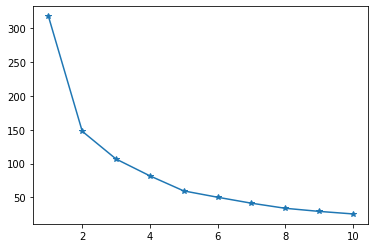

In [ ]:

timeSeriesKmeans.elbow()

130.455 --> 100.483 --> 99.405 --> 98.883 --> 98.809 --> 98.806 --> 98.806 --> 


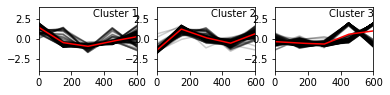

In [ ]:
timeSeriesKmeans.Euclidean_Kmeans()

Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:   11.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


55.671 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.8s finished


6.700 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.7s finished


6.298 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.3s finished


6.143 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


6.084 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.0s finished


6.050 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


6.026 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.0s finished


5.997 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.0s finished


5.990 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.7s finished


5.987 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.3s finished


5.987 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    6.9s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.2s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    6.9s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.0s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.2s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.5s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.4s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.0s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.3s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.3s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.0s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.0s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.0s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.0s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.0s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.0s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.4s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.2s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.7s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.2s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    6.9s finished


5.986 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.2s finished


5.985 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.0s finished


5.985 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.0s finished


5.985 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.0s finished


5.985 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    6.9s finished


5.985 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


5.985 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    6.9s finished


5.985 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    6.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


34.885 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.2s finished


6.098 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.2s finished


5.955 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.3s finished


5.894 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.4s finished


5.885 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.5s finished


5.877 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.2s finished


5.872 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.3s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.3s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.3s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.5s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.4s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.2s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.2s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.6s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.2s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.2s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.2s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.4s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.2s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.6s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.4s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.2s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.2s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.2s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.3s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.2s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.2s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    6.9s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.3s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.2s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.3s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.3s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.2s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.0s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.0s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.2s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.3s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


5.871 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


5.871 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:    7.1s finished


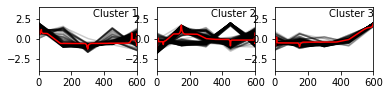

In [ ]:
timeSeriesKmeans.DBA_Kmeans()

2035.865 --> 60.762 --> 63.436 --> 63.906 --> 65.234 --> 65.125 --> 65.056 --> 65.214 --> 65.045 --> 64.828 --> 64.645 --> 64.785 --> 64.694 --> 64.899 --> 64.789 --> 64.721 --> 64.780 --> 64.811 --> 64.770 --> 64.794 --> 64.783 --> 64.773 --> 64.967 --> 64.706 --> 64.867 --> 64.752 --> 64.788 --> 64.767 --> 64.778 --> 64.772 --> 64.781 --> 64.785 --> 64.782 --> 64.811 --> 64.783 --> 64.820 --> 64.783 --> 64.807 --> 64.784 --> 64.741 --> 64.785 --> 64.750 --> 64.792 --> 64.751 --> 64.799 --> 64.753 --> 64.858 --> 64.761 --> 64.774 --> 64.756 --> 


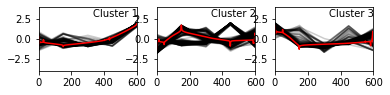

In [ ]:
timeSeriesKmeans.SoftDTW_Kmeans()

# **TASK 4**

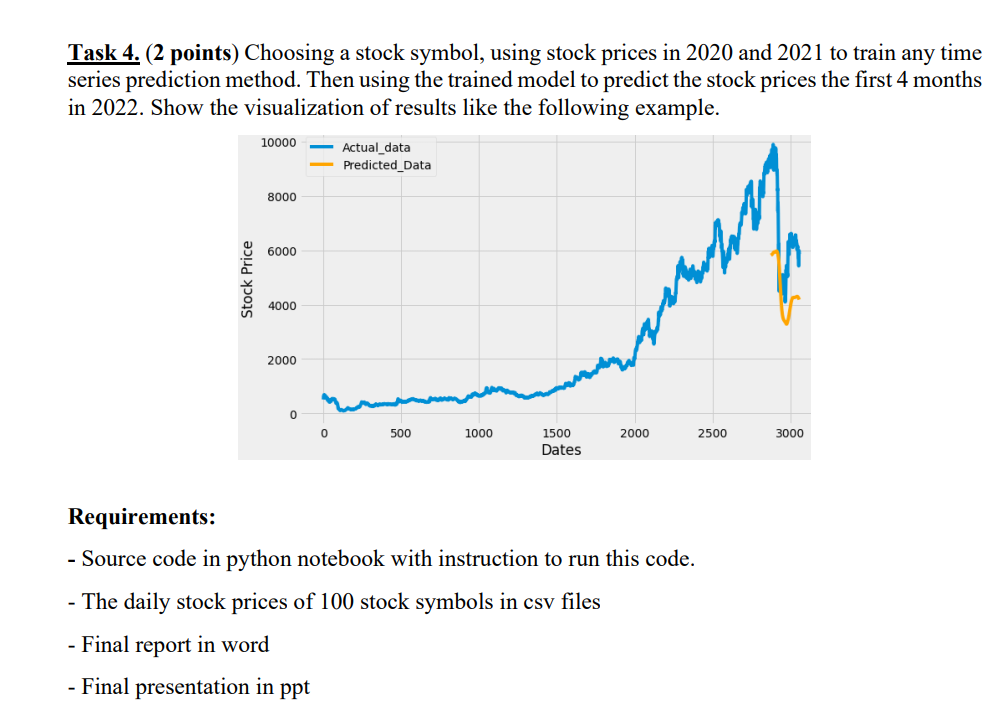

In [ ]:
# đọc dataframe
df = pd.read_csv('/content/data.csv', index_col = 0)
# lấy mã ngân hàng thứ 2 để dự đoán
code = list(df.head(0))[1]
# tạo dataframe cho mã code 
df_LSTM = pd.DataFrame(df[code])
# Chuyển kiểu dữ liệu index sang kiểu dữ liệu date
df_LSTM['Date'] = df_LSTM.index
df_LSTM["Date"] = pd.to_datetime(df_LSTM["Date"])
df_LSTM = df_LSTM.set_index("Date")


In [ ]:
# print dataframe mã code thứ 2
display(df_LSTM)
type(df_LSTM.index)

,ADS
Date,
2020-01-01,11.55
2020-02-01,11.55
2020-03-01,12.00
2020-04-01,12.00
2020-05-01,12.00
...,...
2022-10-27,12.55
2022-10-28,12.70
2022-10-29,12.70


pandas.core.indexes.datetimes.DatetimeIndex

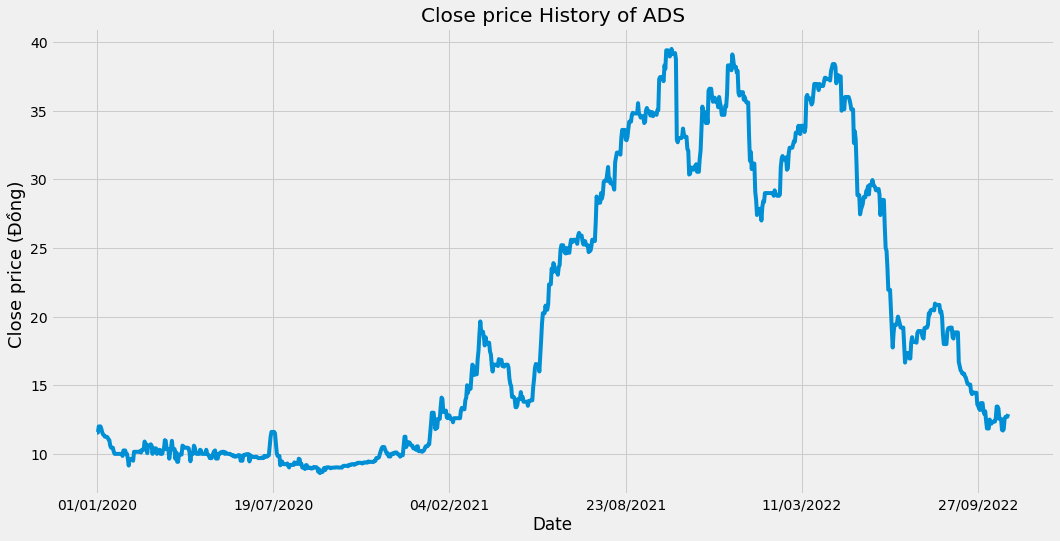

In [ ]:
# bẽ biểu đồ biến động giá đống cửa mã thứ 2
plt.subplots(figsize=(16, 8))
plt.title("Close price History of "+ code)
df[code].plot()
plt.xlabel("Date")
plt.ylabel("Close price (Đồng) ", fontsize =18)
plt.show()

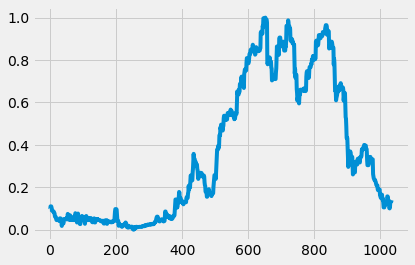

In [ ]:
# Normalized giá đóng cửa về khoảng (0,1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df_LSTM)
plt.plot(scaled_data)
plt.show()


In [ ]:
# kích thước tập train là 2 năm tương ứng 366+365 = 731
train_data_lengh = 731
# tạo dataset để training:
train_data = scaled_data[0:train_data_lengh]
# x_Train dữ liệu dùng để dữ đoán
x_train =[]
# y_train dự liệu được dự đoán từ
y_train = []

#chia dữ liệu thành tập dữ liệu x_Train và 
# huấn luyện giá thứ i+60 bằng tập dữ liệu từ [i-60] đến [i]
for i in range(60, len(train_data )):
  x_train.append(train_data[i-60:i,0]) 
  y_train.append(train_data[i,0])
  if ( i<= 61):
    print(x_train)
    print(y_train)
  

[array([0.09546926, 0.09546926, 0.11003236, 0.11003236, 0.11003236,
       0.10355987, 0.09546926, 0.09061489, 0.08899676, 0.08576052,
       0.08576052, 0.08576052, 0.08414239, 0.07928803, 0.0776699 ,
       0.06472492, 0.05987055, 0.05987055, 0.05987055, 0.05016181,
       0.04530744, 0.04530744, 0.04530744, 0.04530744, 0.04530744,
       0.04530744, 0.04530744, 0.04530744, 0.04530744, 0.04045307,
       0.05339806, 0.05339806, 0.05339806, 0.04530744, 0.04530744,
       0.03398058, 0.01779935, 0.03333333, 0.03333333, 0.03333333,
       0.03333333, 0.02912621, 0.05016181, 0.05016181, 0.05016181,
       0.05016181, 0.05016181, 0.05016181, 0.05016181, 0.05177994,
       0.04854369, 0.05501618, 0.05501618, 0.05501618, 0.07443366,
       0.06796117, 0.06796117, 0.04692557, 0.06472492, 0.06472492])]
[0.06472491909385114]
[array([0.09546926, 0.09546926, 0.11003236, 0.11003236, 0.11003236,
       0.10355987, 0.09546926, 0.09061489, 0.08899676, 0.08576052,
       0.08576052, 0.08576052, 0.084

In [ ]:
# chuyển x_train và y_train  thành array
x_train, y_train = np.array(x_train),np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(671, 60)
(671,)


In [ ]:
# reshape lại x_train dataframe từ(671,60) sang (671,60,1)
print("Before: ",x_train.shape)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
print("After: ",x_train.shape)
print(x_train)

Before:  (671, 60)
After:  (671, 60, 1)
[[[0.09546926]
  [0.09546926]
  [0.11003236]
  ...
  [0.04692557]
  [0.06472492]
  [0.06472492]]

 [[0.09546926]
  [0.11003236]
  [0.11003236]
  ...
  [0.06472492]
  [0.06472492]
  [0.06472492]]

 [[0.11003236]
  [0.11003236]
  [0.11003236]
  ...
  [0.06472492]
  [0.06472492]
  [0.06796117]]

 ...

 [[0.79288026]
  [0.79288026]
  [0.76375405]
  ...
  [0.9579288 ]
  [0.94498382]
  [0.94822006]]

 [[0.79288026]
  [0.76375405]
  [0.7605178 ]
  ...
  [0.94498382]
  [0.94822006]
  [0.89644013]]

 [[0.76375405]
  [0.7605178 ]
  [0.7038835 ]
  ...
  [0.94822006]
  [0.89644013]
  [0.88996764]]]


In [ ]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
# biên dịch model
model.compile(optimizer= 'adam', loss= 'mean_squared_error')

In [ ]:
# Train model
model.fit(x_train,y_train,batch_size=1, epochs =10)

Epoch 1/10
671/671 [==============================] - 25s 30ms/step - loss: 0.0033
Epoch 2/10
671/671 [==============================] - 20s 30ms/step - loss: 0.0020
Epoch 3/10
671/671 [==============================] - 18s 27ms/step - loss: 0.0014
Epoch 4/10
671/671 [==============================] - 18s 27ms/step - loss: 0.0011
Epoch 5/10
671/671 [==============================] - 18s 27ms/step - loss: 0.0011
Epoch 6/10
671/671 [==============================] - 18s 27ms/step - loss: 0.0012
Epoch 7/10
671/671 [==============================] - 18s 27ms/step - loss: 8.8874e-04
Epoch 8/10
671/671 [==============================] - 18s 27ms/step - loss: 7.3546e-04
Epoch 9/10
671/671 [==============================] - 18s 27ms/step - loss: 4.9553e-04
Epoch 10/10
671/671 [==============================] - 18s 27ms/step - loss: 6.5011e-04


In [ ]:
# tạo test data cho 4 tháng còn lại
# test  data sẽ bắt đầu từ vị trí dữ liệu ngày 1/1/2022 trừ đi 60 ngày 
test_data = scaled_data[train_data_lengh-60:,:]
# x_test: dữ liệu input để bỏ vào model dự đoán
x_test = []
# y_test: dùng để so sánh với y_predict được dự đoán bởi model
y_test = df_LSTM[train_data_lengh::]

for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])
  if (i<62):
    print(x_test)



[array([0.7605178 , 0.7038835 , 0.70550162, 0.72006472, 0.72006472,
       0.72006472, 0.71521036, 0.72006472, 0.72491909, 0.72815534,
       0.71035599, 0.71035599, 0.71035599, 0.74110032, 0.7605178 ,
       0.81553398, 0.86407767, 0.85113269, 0.85113269, 0.85113269,
       0.82524272, 0.84142395, 0.82524272, 0.9012945 , 0.90614887,
       0.90614887, 0.90614887, 0.88673139, 0.87540453, 0.88187702,
       0.88511327, 0.87540453, 0.87540453, 0.87540453, 0.86245955,
       0.88673139, 0.87378641, 0.86407767, 0.84466019, 0.84466019,
       0.84466019, 0.84466019, 0.86569579, 0.86407767, 0.89320388,
       0.96116505, 0.96116505, 0.96116505, 0.96116505, 0.94983819,
       0.98705502, 0.97572816, 0.9579288 , 0.9579288 , 0.9579288 ,
       0.94498382, 0.94822006, 0.89644013, 0.88996764, 0.89805825])]
[array([0.7605178 , 0.7038835 , 0.70550162, 0.72006472, 0.72006472,
       0.72006472, 0.71521036, 0.72006472, 0.72491909, 0.72815534,
       0.71035599, 0.71035599, 0.71035599, 0.74110032, 0.7

In [ ]:
# Chuyển x_test sang numpy array
x_test = np.array(x_test)
# reshape x_test từ (304,60) sang (304,60,1)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
print(x_test.shape)

(304, 60, 1)


In [ ]:
# Lấy  mô hình  để dự đoán giá trị thứ 61
# predictions là list các giá trị y được dự đoán từng ngày trong 4 tháng 
predictions = model.predict(x_test)
print(predictions )


10/10 [==============================] - 0s 14ms/step
[[0.9208149 ]
 [0.9239999 ]
 [0.92400694]
 [0.923779  ]
 [0.9055115 ]
 [0.9110716 ]
 [0.905139  ]
 [0.90004754]
 [0.90049016]
 [0.90135545]
 [0.82181585]
 [0.7576777 ]
 [0.77674913]
 [0.7472422 ]
 [0.7558862 ]
 [0.75948554]
 [0.7597679 ]
 [0.6968685 ]
 [0.6690218 ]
 [0.6365901 ]
 [0.6454811 ]
 [0.65213424]
 [0.65361446]
 [0.6533321 ]
 [0.62814766]
 [0.65042156]
 [0.6701888 ]
 [0.67136806]
 [0.6889807 ]
 [0.69174993]
 [0.69058776]
 [0.68968344]
 [0.68932545]
 [0.68915814]
 [0.6889741 ]
 [0.68872565]
 [0.68843585]
 [0.68814147]
 [0.6819092 ]
 [0.6925152 ]
 [0.6888475 ]
 [0.6843388 ]
 [0.680581  ]
 [0.6802119 ]
 [0.68052495]
 [0.68369627]
 [0.744666  ]
 [0.7739266 ]
 [0.7796683 ]
 [0.7690612 ]
 [0.76610595]
 [0.7662974 ]
 [0.7715124 ]
 [0.7445718 ]
 [0.7432246 ]
 [0.77905446]
 [0.7975159 ]
 [0.79715943]
 [0.7946964 ]
 [0.79368466]
 [0.8014953 ]
 [0.81066746]
 [0.8097852 ]
 [0.829537  ]
 [0.8318929 ]
 [0.83047855]
 [0.84576523]
 [0.8314

In [ ]:
# transforme trở về dữ liệu ban đầu
predictions = scaler.inverse_transform(predictions )
print(predictions)



[[37.053177 ]
 [37.151596 ]
 [37.151814 ]
 [37.144768 ]
 [36.580303 ]
 [36.752113 ]
 [36.568794 ]
 [36.41147  ]
 [36.425144 ]
 [36.45188  ]
 [33.994106 ]
 [32.012238 ]
 [32.601547 ]
 [31.689783 ]
 [31.956882 ]
 [32.068104 ]
 [32.076824 ]
 [30.133236 ]
 [29.272774 ]
 [28.270636 ]
 [28.545366 ]
 [28.750948 ]
 [28.796686 ]
 [28.787962 ]
 [28.009764 ]
 [28.698027 ]
 [29.308834 ]
 [29.345274 ]
 [29.889503 ]
 [29.975073 ]
 [29.939161 ]
 [29.911219 ]
 [29.900156 ]
 [29.894987 ]
 [29.8893   ]
 [29.881622 ]
 [29.872667 ]
 [29.863571 ]
 [29.670994 ]
 [29.99872  ]
 [29.885387 ]
 [29.746069 ]
 [29.629951 ]
 [29.618547 ]
 [29.628222 ]
 [29.726215 ]
 [31.610176 ]
 [32.51433  ]
 [32.69175  ]
 [32.36399  ]
 [32.272675 ]
 [32.27859  ]
 [32.43973  ]
 [31.607267 ]
 [31.56564  ]
 [32.672783 ]
 [33.24324  ]
 [33.232224 ]
 [33.15612  ]
 [33.124855 ]
 [33.366203 ]
 [33.649624 ]
 [33.622364 ]
 [34.232693 ]
 [34.305492 ]
 [34.261784 ]
 [34.734142 ]
 [34.290737 ]
 [34.102093 ]
 [34.703518 ]
 [34.7965   ]
 [34.7

In [ ]:
# Sai số toàn phương trung bình
rmse = np.sqrt(np.mean(predictions- y_test)**2)
print(rmse)

ADS    0.760604
dtype: float64


In [ ]:
# vẽ biểu đồ
# Dữ liệu traning 2020,2021

# tao dataframe bao gồm dữ liệu dữ y_test và y được dự đoán
valid = df_LSTM[train_data_lengh:train_data_lengh+120]
valid.index = valid.index.strftime('%d/%m/%Y')
valid ['Predcitions']=predictions[:120:]
valid.index = valid.index.astype('string')

print(valid)


              ADS  Predcitions
Date                          
01/01/2022  36.35    37.053177
01/02/2022  36.35    37.151596
01/03/2022  36.35    37.151814
01/04/2022  35.80    37.144768
01/05/2022  36.00    36.580303
...           ...          ...
26/04/2022  35.20    35.693691
27/04/2022  35.50    35.731850
28/04/2022  35.10    36.262856
29/04/2022  36.00    35.967670
30/04/2022  36.00    36.840118

[120 rows x 2 columns]


<ipython-input-55-cde205a0fede>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid ['Predcitions']=predictions[:120:]


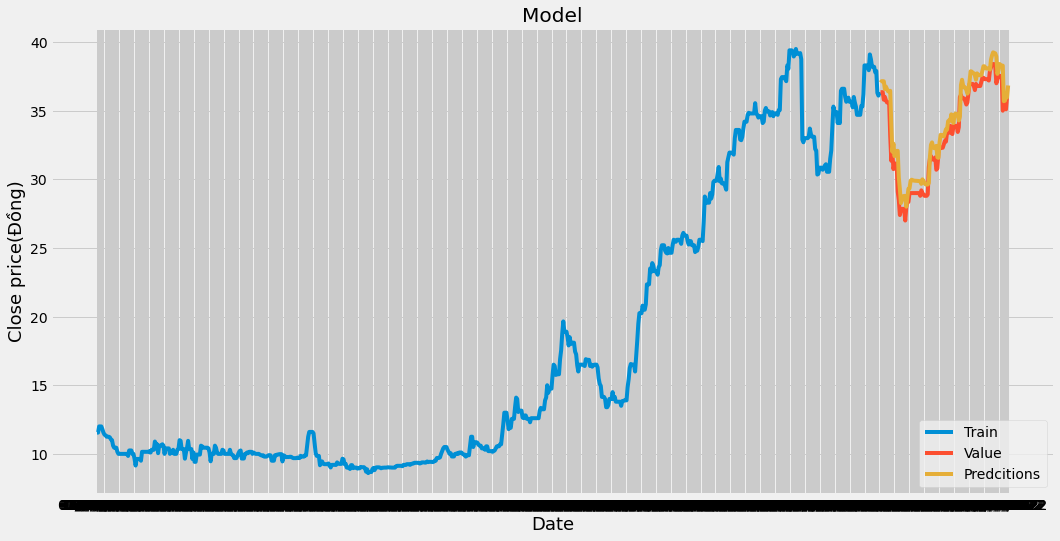

In [ ]:
# vẽ biểu đồ
plt.figure(figsize =(16,8))
plt.title("Model")
plt.xlabel("Date",fontsize = 18)
plt.ylabel("Close price(Đồng)",fontsize=18)
plt.plot(df[code][:train_data_lengh:])
# plt.xticks(851, [i for i in range(851)],rotation=20) 
plt.plot(valid[[code,'Predcitions']])
plt.legend(['Train','Value','Predcitions'],loc = 'lower right')

plt.show()

